# Importation des bibliothèques

In [14]:
import numpy as np
import pandas as pd
from pprint import pprint

import re
import spacy
import fr_core_news_sm
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

from sklearn.datasets import load_files
import pickle
import sklearn.externals as extjoblib
import joblib


from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


import sklearn.metrics
import mlflow

import matplotlib.pyplot as plt
import seaborn as sns


ModuleNotFoundError: No module named 'numpy'

# Chargement des données

In [16]:
#DONNEE BRUTE

df = pd.read_excel("/Users/manon/Projet/IA_Processing/labels-voix-ca-lot-6-reduit.xlsx")
df = df[['text', 'category', 'is_project']]

NameError: name 'pd' is not defined

In [4]:
df

,text,category,is_project
0,Tél cliente le 05/02/20 : Etudiante en M2 Hydr...,Montant,False
1,Tél cliente le 05/02/20 : Etudiante en M2 Hydr...,Date,False
2,Tél cliente le 05/02/20 : Etudiante en M2 Hydr...,Date,False
3,Tél cliente le 05/02/20 : Etudiante en M2 Hydr...,Date,False
4,Tél cliente le 05/02/20 : Etudiante en M2 Hydr...,Date,False
...,...,...,...
8716,proposition pret pour acquisition nouvelle voi...,Credit_vehicule,False
8717,proposition pret pour acquisition nouvelle voi...,Point_d_attention_risques,False
8718,Refus de pret conso 7Ke sur 36 mois car M. sou...,Montant,False
8719,Refus de pret conso 7Ke sur 36 mois car M. sou...,Credit_vehicule,True


In [17]:
df.category

0                         Montant
1                            Date
2                            Date
3                            Date
4                            Date
                  ...            
8716              Credit_vehicule
8717    Point_d_attention_risques
8718                      Montant
8719              Credit_vehicule
8720                         Date
Name: category, Length: 8721, dtype: object

In [15]:
df.text[0]

"Tél cliente le 05/02/20 : Etudiante en M2 Hydrologie sur Mtp à la Fac de Sciences, c'est ça dernière année d'étude. \r\nVa partir changer de ville et repartir en stage à partir de début mars 2020. \r\nActuellement hébergée par sa mère, mais va devoir prendre un appartement. Sa mère est client CA et retraité du CIRAD (cf : dernier rapport prêt étudiant fait en 2017). \r\nSa mère lui verse en moyenne 200€/m et travaille en intérim. Mutuelle chez Coverlife. L. Fuentes 05/02/20"

# Visualisation de donnée

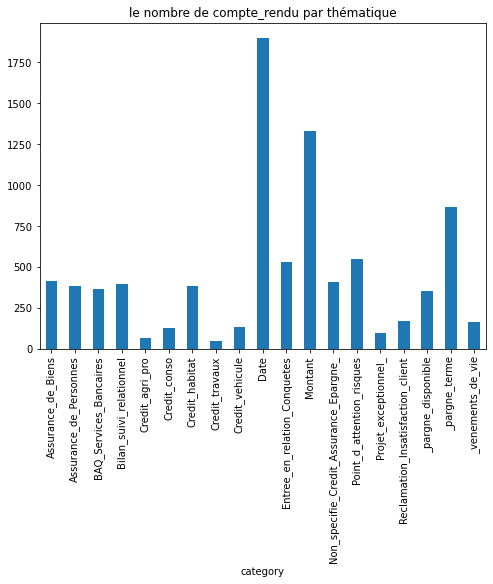

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
plt.title("le nombre de compte_rendu par thématique")
df.groupby('category').text.count().plot.bar(ylim=0)
plt.show()

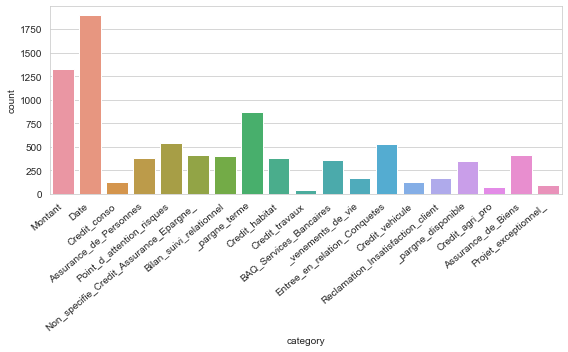

In [7]:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='category', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [8]:
#Nombre de comptes rendus en fonction des thématiques
print(pd.crosstab(index=df["category"],columns="count"))

col_0                                   count
category                                     
Assurance_de_Biens                        413
Assurance_de_Personnes                    382
BAQ_Services_Bancaires                    363
Bilan_suivi_relationnel                   398
Credit_agri_pro                            69
Credit_conso                              128
Credit_habitat                            385
Credit_travaux                             45
Credit_vehicule                           132
Date                                     1897
Entree_en_relation_Conquetes              529
Montant                                  1332
Non_specifie_Credit_Assurance_Epargne_    409
Point_d_attention_risques                 546
Projet_exceptionnel_                       95
Reclamation_Insatisfaction_client         168
_pargne_disponible                        355
_pargne_terme                             866
_venements_de_vie                         166


# Encoding dataframe

In [9]:
       df_s = df.groupby(['text', 'category'])['is_project'].first().unstack(-1)
       df_s = (~df_s.isna()).astype(int)

       # Les noms des colonnes cibles
       category_cols = [
              'Credit_vehicule', 'Bilan_suivi_relationnel',
             '_pargne_terme', 
             #'Credit_travaux', 
             'Entree_en_relation_Conquetes',
             'Point_d_attention_risques', 'Reclamation_Insatisfaction_client',
             'Credit_conso', 
             #'_venements_de_vie','Credit_agri_pro',
              '_pargne_disponible',
              'Non_specifie_Credit_Assurance_Epargne_', 'Assurance_de_Biens',
             'Assurance_de_Personnes', 'BAQ_Services_Bancaires',
              'Credit_habitat',  'Projet_exceptionnel_']

df_s = df_s.reset_index()

In [10]:
print("Number of rows in data =",df_s.shape[0])
print("Number of columns in data =",df_s.shape[1])
print("\n")
print("**Sample data:**")
df_s.head()

Number of rows in data = 1450
Number of columns in data = 20


**Sample data:**


category,text,Assurance_de_Biens,Assurance_de_Personnes,BAQ_Services_Bancaires,Bilan_suivi_relationnel,Credit_agri_pro,Credit_conso,Credit_habitat,Credit_travaux,Credit_vehicule,Date,Entree_en_relation_Conquetes,Montant,Non_specifie_Credit_Assurance_Epargne_,Point_d_attention_risques,Projet_exceptionnel_,Reclamation_Insatisfaction_client,_pargne_disponible,_pargne_terme,_venements_de_vie
0,\n\n reçu madame ce jour pour mise sous tutell...,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1
1,\n Clause bénéficiaire revue et modifié pour u...,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0
2,\n Prise de rendez-vous avec Caroline JIORDA p...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,\n client prospect (CA centre france) projet ...,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
4,\n conversation avec la cliente ce jour en app...,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


# Suppresion collonne peut/trop représenter

In [11]:
df_s = df_s.drop(['Montant','Date', 'Credit_agri_pro', 'Credit_travaux', '_venements_de_vie'], axis = 1)
df_s.head()

category,text,Assurance_de_Biens,Assurance_de_Personnes,BAQ_Services_Bancaires,Bilan_suivi_relationnel,Credit_conso,Credit_habitat,Credit_vehicule,Entree_en_relation_Conquetes,Non_specifie_Credit_Assurance_Epargne_,Point_d_attention_risques,Projet_exceptionnel_,Reclamation_Insatisfaction_client,_pargne_disponible,_pargne_terme
0,\n\n reçu madame ce jour pour mise sous tutell...,0,0,0,1,0,0,0,1,0,1,0,0,0,0
1,\n Clause bénéficiaire revue et modifié pour u...,0,0,0,1,0,0,0,0,1,1,0,0,0,1
2,\n Prise de rendez-vous avec Caroline JIORDA p...,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,\n client prospect (CA centre france) projet ...,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,\n conversation avec la cliente ce jour en app...,0,0,0,1,1,0,0,0,0,0,0,0,0,0


# Prepross texte

In [12]:
df_s.text = df_s.text.astype(str)

In [13]:
transformer = FunctionTransformer()
transformer.transform(df_s['text'])

0       \n\n reçu madame ce jour pour mise sous tutell...
1       \n Clause bénéficiaire revue et modifié pour u...
2       \n Prise de rendez-vous avec Caroline JIORDA p...
3       \n client prospect (CA centre france)  projet ...
4       \n conversation avec la cliente ce jour en app...
                              ...                        
1445    vu pdt covid à ,l'agence pour défectuosité de ...
1446    vu pour crédit auto 5 000 euros sur 72 mois + ...
1447    vu pour entretien réaménagement prêt: mais 3em...
1448         échange téléphonique ce jour sur les mesures
1449    école prepa sur mtp math - lycee joffre à part...
Name: text, Length: 1450, dtype: object

In [14]:
# Chargement stopwords français
stop_words = stopwords.words('french')
    
# Initialize stemmer, which will take words and convert words to their "stem," e.g. Playing-> Play
ps = PorterStemmer() 

# Enlever les charactères nons alphabétiques, espaces et convertir toutes les lettres en minuscules
# References: https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/
def clean_text(txt): 
    txt = txt.lower()   #lowercase
    txt = re.sub("[^a-zA-Z]"," ",txt) #Remove everything except alphabetical characters 
    txt = word_tokenize(txt) #tokenize (split into list and remove whitespace)
    
    #initialize list to store clean text
    clean_text=""
      
    #iterate over each word
    for w in txt:      
        #remove stopwords
        if w not in stop_words:
            #stem=ps.stem(w) #stem 
            stem = w
            clean_text += stem +" " 
    return clean_text


text_new =[] #declare a list to hold new movies

for cell in df_s['text']:    
    txt = clean_text(cell)
    text_new.append(txt)
    
#add new info column to the dataframe
df_s['text'] = text_new 
df_s.head(1)


category,text,Assurance_de_Biens,Assurance_de_Personnes,BAQ_Services_Bancaires,Bilan_suivi_relationnel,Credit_conso,Credit_habitat,Credit_vehicule,Entree_en_relation_Conquetes,Non_specifie_Credit_Assurance_Epargne_,Point_d_attention_risques,Projet_exceptionnel_,Reclamation_Insatisfaction_client,_pargne_disponible,_pargne_terme
0,re u madame jour mise sous tutelle poux projet...,0,0,0,1,0,0,0,1,0,1,0,0,0,0


In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings

data = df_s

if not sys.warnoptions:
    warnings.simplefilter("ignore")
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]', r' ',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n", " ")
    return cleaned

def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

data['text'] = data['text'].str.lower()
data['text'] = data['text'].apply(cleanHtml)
data['text'] = data['text'].apply(cleanPunc)
data['text'] = data['text'].apply(keepAlpha)

In [16]:
stop_words = set(stopwords.words('english'))
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
data['text'] = data['text'].apply(removeStopWords)

In [17]:
stemmer = SnowballStemmer("french")

def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
data['text'] = data['text'].apply(stemming)

In [15]:
data.shape

(1450, 15)

# Modele

In [36]:
pipe_decision_tree = make_pipeline(
    CountVectorizer(),
    TfidfTransformer(),
    MultiOutputClassifier(
       estimator=DecisionTreeClassifier(random_state=0)
    )
)

pipe_decision_tree.fit(data["text"], df_s[category_cols])

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=0)))])

## train test

In [37]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], df_s[category_cols], random_state = 0)

In [38]:
vectorizer = CountVectorizer()
X_train= vectorizer.fit_transform(X_train)


Tfidf = TfidfTransformer()
X_train = Tfidf.fit_transform(X_train)


In [39]:
pipe_decision_tree.fit(X_train, y_train)

AttributeError: lower not found

# Recherche hyper parametres

In [32]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [37]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV

parameters = {'criterion':['gini','entropy'],'min_samples_split' : range(10,500,20),'max_depth': range(1,150,20)}
clf_tree = DecisionTreeClassifier()
clf = GridSearchCV(clf_tree,parameters)

clf.fit(X_train,y_train)

clf.best_estimator_

DecisionTreeClassifier(max_depth=121, min_samples_split=50)

# Prediction 

In [66]:
test = np.array(["Madame est venu ce jour me redonner son ancienne carte bancaire. Elle souhaite également inverstir dans un appartement"])


### Pipe decision tree

In [19]:
predict_decision_tree = pipe_decision_tree.predict(X_test)

In [20]:
from sklearn import metrics
print(metrics.classification_report(y_test, predict_decision_tree, target_names=category_cols))

                                        precision    recall  f1-score   support

                       Credit_vehicule       0.58      0.62      0.60        29
               Bilan_suivi_relationnel       0.53      0.45      0.49        82
                         _pargne_terme       0.77      0.72      0.75       118
          Entree_en_relation_Conquetes       0.69      0.73      0.71        84
             Point_d_attention_risques       0.49      0.42      0.45        84
     Reclamation_Insatisfaction_client       0.35      0.37      0.36        35
                          Credit_conso       0.64      0.50      0.56        32
                    _pargne_disponible       0.85      0.82      0.84        56
Non_specifie_Credit_Assurance_Epargne_       0.41      0.41      0.41        70
                    Assurance_de_Biens       0.74      0.78      0.76        63
                Assurance_de_Personnes       0.76      0.73      0.75        64
                BAQ_Services_Bancaires 

In [21]:
score_decision_tree = pipe_decision_tree.score(X_test, y_test)
score_decision_tree

0.14049586776859505

## visualisation confusion matrix

In [28]:
from sklearn.metrics import multilabel_confusion_matrix

confusion = multilabel_confusion_matrix(y_test, predict_decision_tree)
confusion = np.asarray(confusion)

In [29]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

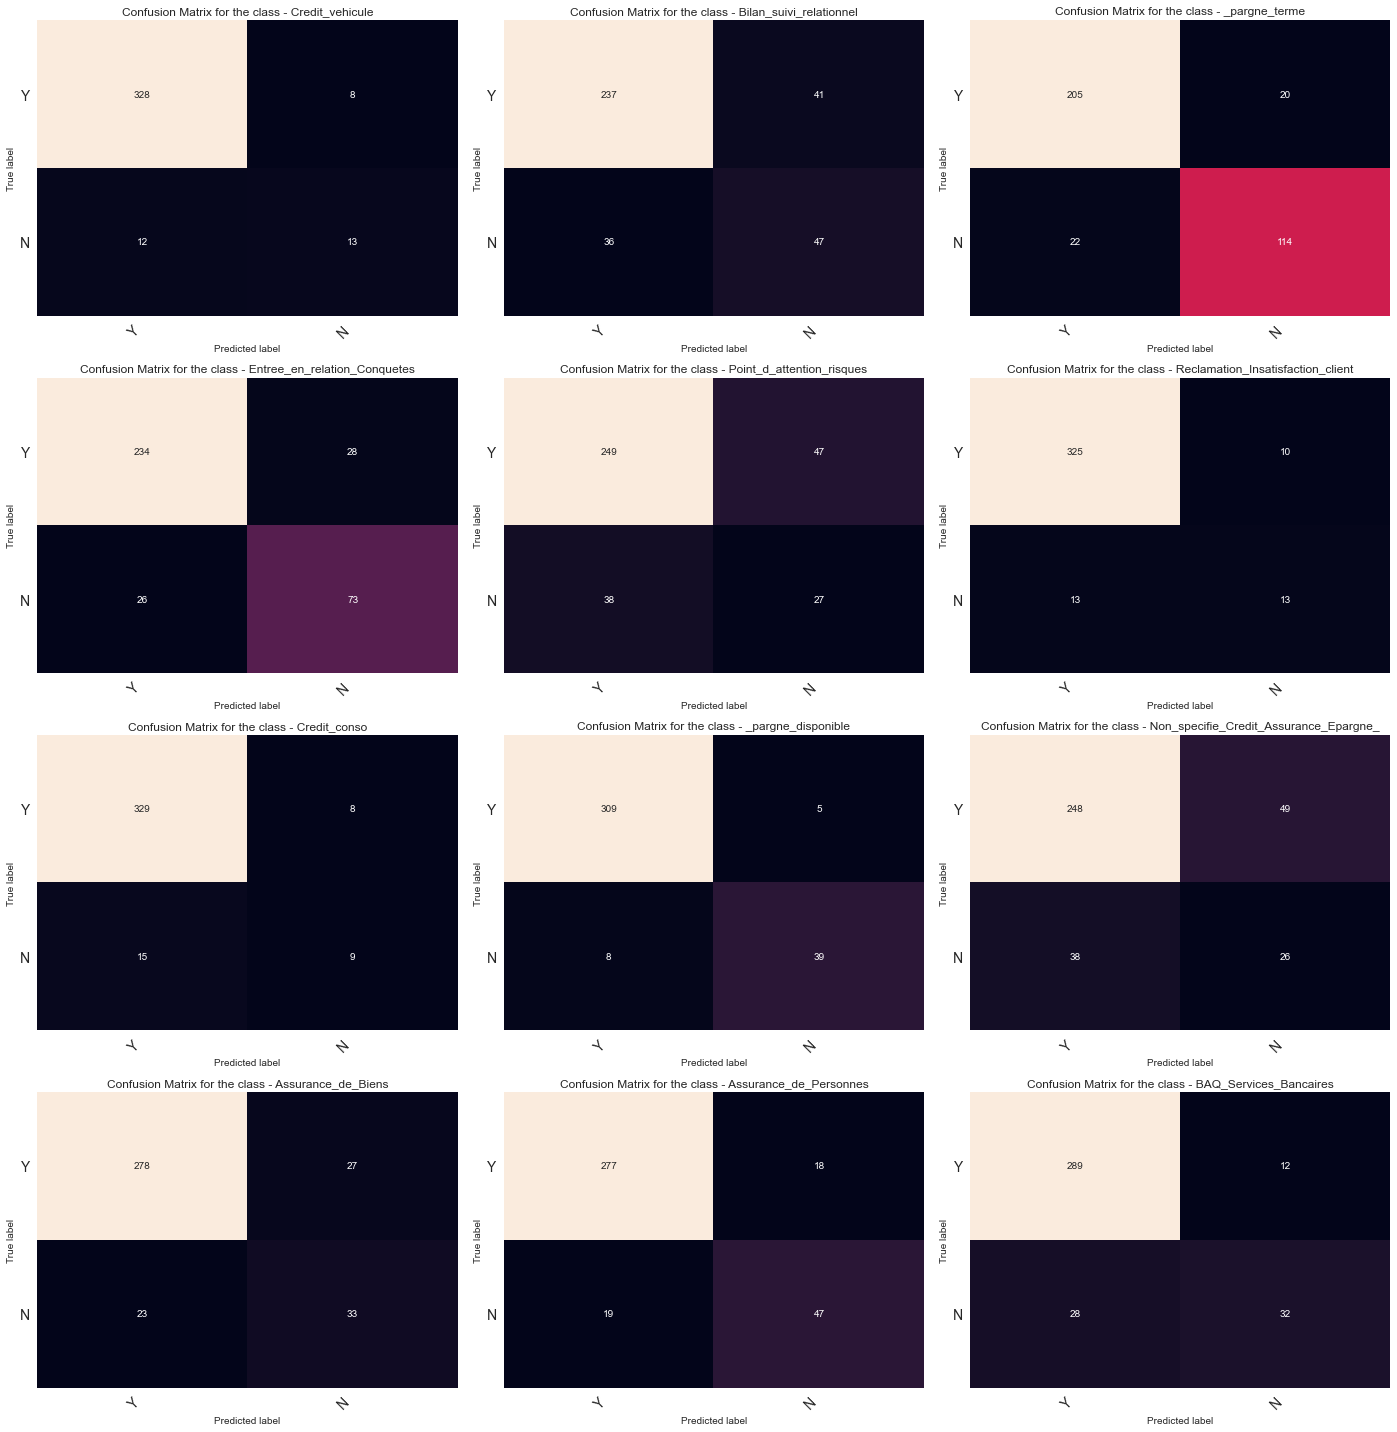

In [30]:
fig, ax = plt.subplots(4, 3, figsize=(20, 20))
    
for axes, cfs_matrix, label in zip(ax.flatten(), confusion, df_s[category_cols]):
        print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

## hyper paramere decision tree

In [26]:
predict_decision_tree2 = pipe_decision_tree2.predict(X_test)

In [27]:
from sklearn import metrics
print(metrics.classification_report(y_test, predict_decision_tree2, target_names=category_cols))

                                        precision    recall  f1-score   support

                       Credit_vehicule       0.55      0.38      0.45        29
               Bilan_suivi_relationnel       0.54      0.41      0.47        82
                         _pargne_terme       0.77      0.78      0.78       118
          Entree_en_relation_Conquetes       0.66      0.77      0.71        84
             Point_d_attention_risques       0.51      0.43      0.47        84
     Reclamation_Insatisfaction_client       0.41      0.63      0.49        35
                          Credit_conso       0.68      0.53      0.60        32
                    _pargne_disponible       0.85      0.82      0.84        56
Non_specifie_Credit_Assurance_Epargne_       0.39      0.46      0.42        70
                    Assurance_de_Biens       0.74      0.67      0.70        63
                Assurance_de_Personnes       0.76      0.78      0.77        64
                BAQ_Services_Bancaires 

In [28]:
score_decision_tree2 = pipe_decision_tree.score(X_test, y_test)
score_decision_tree2

0.14049586776859505

# Sauvegarde du model

In [33]:
joblib.dump(pipe_decision_tree, 'model_decision_tree.pkl')
print("Model dumped!")

Model dumped!


In [34]:
model_decision_tree = joblib.load('model_decision_tree.pkl')

In [35]:
print(model_decision_tree)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('tfidftransformer', TfidfTransformer()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=0)))])


# Sauvegarde du df 

In [37]:
df.to_csv(r'C:/Users/ET03349/Desktop/Sémantique/Lot_voix_ca/lot_7.csv',index=False)

# ML Flow

In [34]:
def fetch_logged_data(run_id):
    client = mlflow.tracking.MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts

# enable autologging
mlflow.sklearn.autolog()

# prepare training data
X_train, X_test, y_train, y_test = train_test_split(df_s['text'], df_s[category_cols], random_state = 0)

# train a model
pipe = Pipeline([
    ('countVectorier', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    # Pour gérer les cas multi-label
    ('multiclass', MultiOutputClassifier(
    # Le solveur par defaut est lent dans le cas sparse
       estimator=DecisionTreeClassifier(random_state=0)
    ))
])

with mlflow.start_run() as run:
    pipe.fit(X_train, y_train)

# fetch logged data
params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)

pprint(params)

pprint(metrics)

pprint(tags)

pprint(artifacts)


Exception: Run with UUID e7acd32b822f428a8e6337eb55577332 is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

In [25]:
import os
from random import random, randint
from mlflow import log_metric, log_param, log_artifacts

if __name__ == "__main__":
    # Log a parameter (key-value pair)
    log_param("param1", randint(0, 100))

    # Log a metric; metrics can be updated throughout the run
    log_metric("foo", random())
    log_metric("foo", random() + 1)
    log_metric("foo", random() + 2)

    # Log an artifact (output file)
    if not os.path.exists("outputs"):
        os.makedirs("outputs")
    with open("outputs/test.txt", "w") as f:
        f.write("hello world!")
    log_artifacts("outputs")

/bin/bash: mlflow: command not found
